In [1]:
import os
import pandas as pd
import librosa 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import IPython.display as idp
from tensorflow.keras.models import load_model

C:\Users\gogik\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
dat1, sampling_rate1 = librosa.load('C:/Users/gogik/Downloads/archive/fold6/98680-9-0-2.wav')
dat2, sampling_rate2 = librosa.load('C:/Users/gogik/Downloads/archive/fold2/96475-9-0-5.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

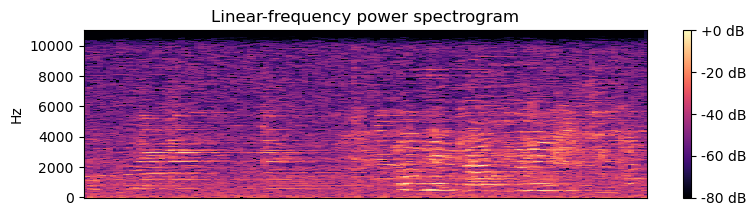

In [3]:
import librosa.display
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

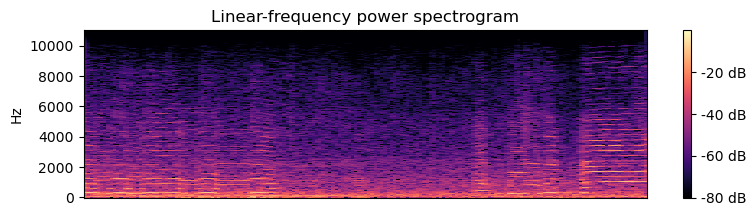

In [4]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [5]:
audio_dataset_path = 'C:/Users/gogik/Downloads/archive/'
df = pd.read_csv('C:/Users/gogik/Downloads/archive/UrbanSound8K.csv')
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
#!pip install opencv-python
import cv2
X = []
y = []
up_width = 173
up_height = 40
for data in df.iterrows():
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(data[1][5])+'/',str(data[1][0]))
    raw , sr = librosa.load(file_name, res_type='kaiser_fast')
    X_ = librosa.feature.mfcc(y=raw, sr=sr, n_mfcc=40)
    up_points = (up_width, up_height)
    X_ = cv2.resize(X_, up_points, interpolation= cv2.INTER_LINEAR)
    X.append(X_)
    y.append(data[1][7])

C:\Users\gogik\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
C:\Users\gogik\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\gogik\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
print(X.shape)
print(y.shape)

(8732, 40, 173)
(8732,)


In [9]:
y = to_categorical(le.fit_transform(y))
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [10]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (8732, 40, 173, 1)
y Shape is:  (8732, 10)


In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=25)

In [12]:
ip = (up_height,up_width,1)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
model =  models.Sequential([
    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = ip),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(256 , activation = 'relu'),
                          layers.Dense(256 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 171, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 64)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 42, 64)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 40, 128)        7

In [14]:
cnn=model.fit(X_train,y_train,epochs=30,batch_size=30,validation_data=(X_test,y_test))

Epoch 1/30
233/233 [==============================] - 24s 100ms/step - loss: 1.5594 - accuracy: 0.4510 - val_loss: 1.1549 - val_accuracy: 0.5936
Epoch 2/30
233/233 [==============================] - 24s 102ms/step - loss: 1.0095 - accuracy: 0.6407 - val_loss: 0.8894 - val_accuracy: 0.7172
Epoch 3/30
233/233 [==============================] - 24s 102ms/step - loss: 0.7349 - accuracy: 0.7422 - val_loss: 0.6456 - val_accuracy: 0.7939
Epoch 4/30
233/233 [==============================] - 25s 107ms/step - loss: 0.5741 - accuracy: 0.8013 - val_loss: 0.5422 - val_accuracy: 0.8231
Epoch 5/30
233/233 [==============================] - 24s 101ms/step - loss: 0.4793 - accuracy: 0.8389 - val_loss: 0.4903 - val_accuracy: 0.8437
Epoch 6/30
233/233 [==============================] - 23s 101ms/step - loss: 0.4052 - accuracy: 0.8614 - val_loss: 0.4358 - val_accuracy: 0.8598
Epoch 7/30
233/233 [==============================] - 24s 102ms/step - loss: 0.3513 - accuracy: 0.8766 - val_loss: 0.3883 - val_ac

In [18]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)
score=model.evaluate(X_test,y_test)
print(score)

55/55 [==============================] - 1s 20ms/step - loss: 0.2940 - accuracy: 0.9176
[0.29397010803222656, 0.9175729751586914]


In [35]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_pred,y_test)

0.9129937034917001

In [36]:
print(tf.__version__)

2.10.0


In [37]:
model.save('model.h5')

In [38]:
from tensorflow.keras.models import load_model
modelUrban=load_model('model.h5')

In [39]:
modelUrban.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 171, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 64)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 42, 64)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 40, 128)        7

In [40]:
loss,accuracy=modelUrban.evaluate(X_test,y_test,verbose=1)

55/55 [==============================] - 1s 20ms/step - loss: 0.2940 - accuracy: 0.9176


In [41]:
print(loss)

0.29397010803222656


In [42]:
print(accuracy)

0.9175729751586914


In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(modelUrban)
converter.experimental_new_converter = True
tflite_model = converter.convert()

open('model.tflite','wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\gogik\AppData\Local\Temp\tmpa7sdn4p0\assets


INFO:tensorflow:Assets written to: C:\Users\gogik\AppData\Local\Temp\tmpa7sdn4p0\assets


780764